# Fitting a resonator measured in reflection

In [1]:
%matplotlib notebook
from typing import Dict, List
import itertools


from resonator_tools import circuit
import numpy as np
import pandas as pd
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, FloatSlider, RadioButtons
import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.style.use('my_official')

GHz = 10**9

In [3]:
def resonator_kernel(freq_list: List[float], system_parameters: Dict):
    try:
        return (
            1 - (
                system_parameters["Q_load"]
                / system_parameters["Q_coupling"]
                * np.exp(1j * system_parameters["phi"])
            ) / (
                1
                + 1j
                * 2
                * system_parameters["Q_load"]
                * (freq_list / system_parameters["f_res"] - 1)
            )
        ) * (
            system_parameters["att"]
            * np.exp(
                -1j
                * 2
                * np.pi
                * freq_list
                * system_parameters["tau"])
        )
    except KeyError as err:
        raise RuntimeError(f"Missing dictionary entry: {err}")


def resonator_kernel_transmission(freq_list: List[float], system_parameters: Dict):
    try:
        return (
            system_parameters["Q_load"]
            / system_parameters["Q_coupling"]
            * np.exp(1j * system_parameters["phi"])
        ) / (
            1
            + 1j
            * 2
            * system_parameters["Q_load"]
            * (freq_list / system_parameters["f_res"] - 1)
        ) * (
            system_parameters["att"]
            * np.exp(
                -1j
                * 2
                * np.pi
                * freq_list
                * system_parameters["tau"])
        )
    except KeyError as err:
        raise RuntimeError(f"Missing dictionary entry: {err}")


def generate_freq_list(f_central: float, f_sd: float, size: int) -> List[float]:
    """Gaussian distribution"""
    return np.sort(
        np.random.normal(
            loc=f_central,
            scale=f_sd,
            size=size))


def generate_size_list(f_central: float, freq_list: List[float]) -> List[int]:
    """Resonance frequency point given bigger size"""
    f_res_idx = len(
        list(
            itertools.takewhile(
                lambda x: x < f_central, freq_list)))
    size_list = [1] * len(freq_list)
    size_list[f_res_idx] = 20

    return size_list

In [4]:
system_parameters = {
    "f_res": 5 * GHz,
    "Q_load": 100,
    "Q_coupling": 10,
    "phi": 0,
    "att": 1,
    "tau": 0
}
simulation_parameters = {
    "N": 1000,
    "spread_dev": GHz / 5
}

# Evaluate once
freq_list = generate_freq_list(
    system_parameters["f_res"],
    simulation_parameters["spread_dev"],
    simulation_parameters["N"])

size_list = generate_size_list(system_parameters["f_res"], freq_list)

# Notch

<IPython.core.display.Javascript object>


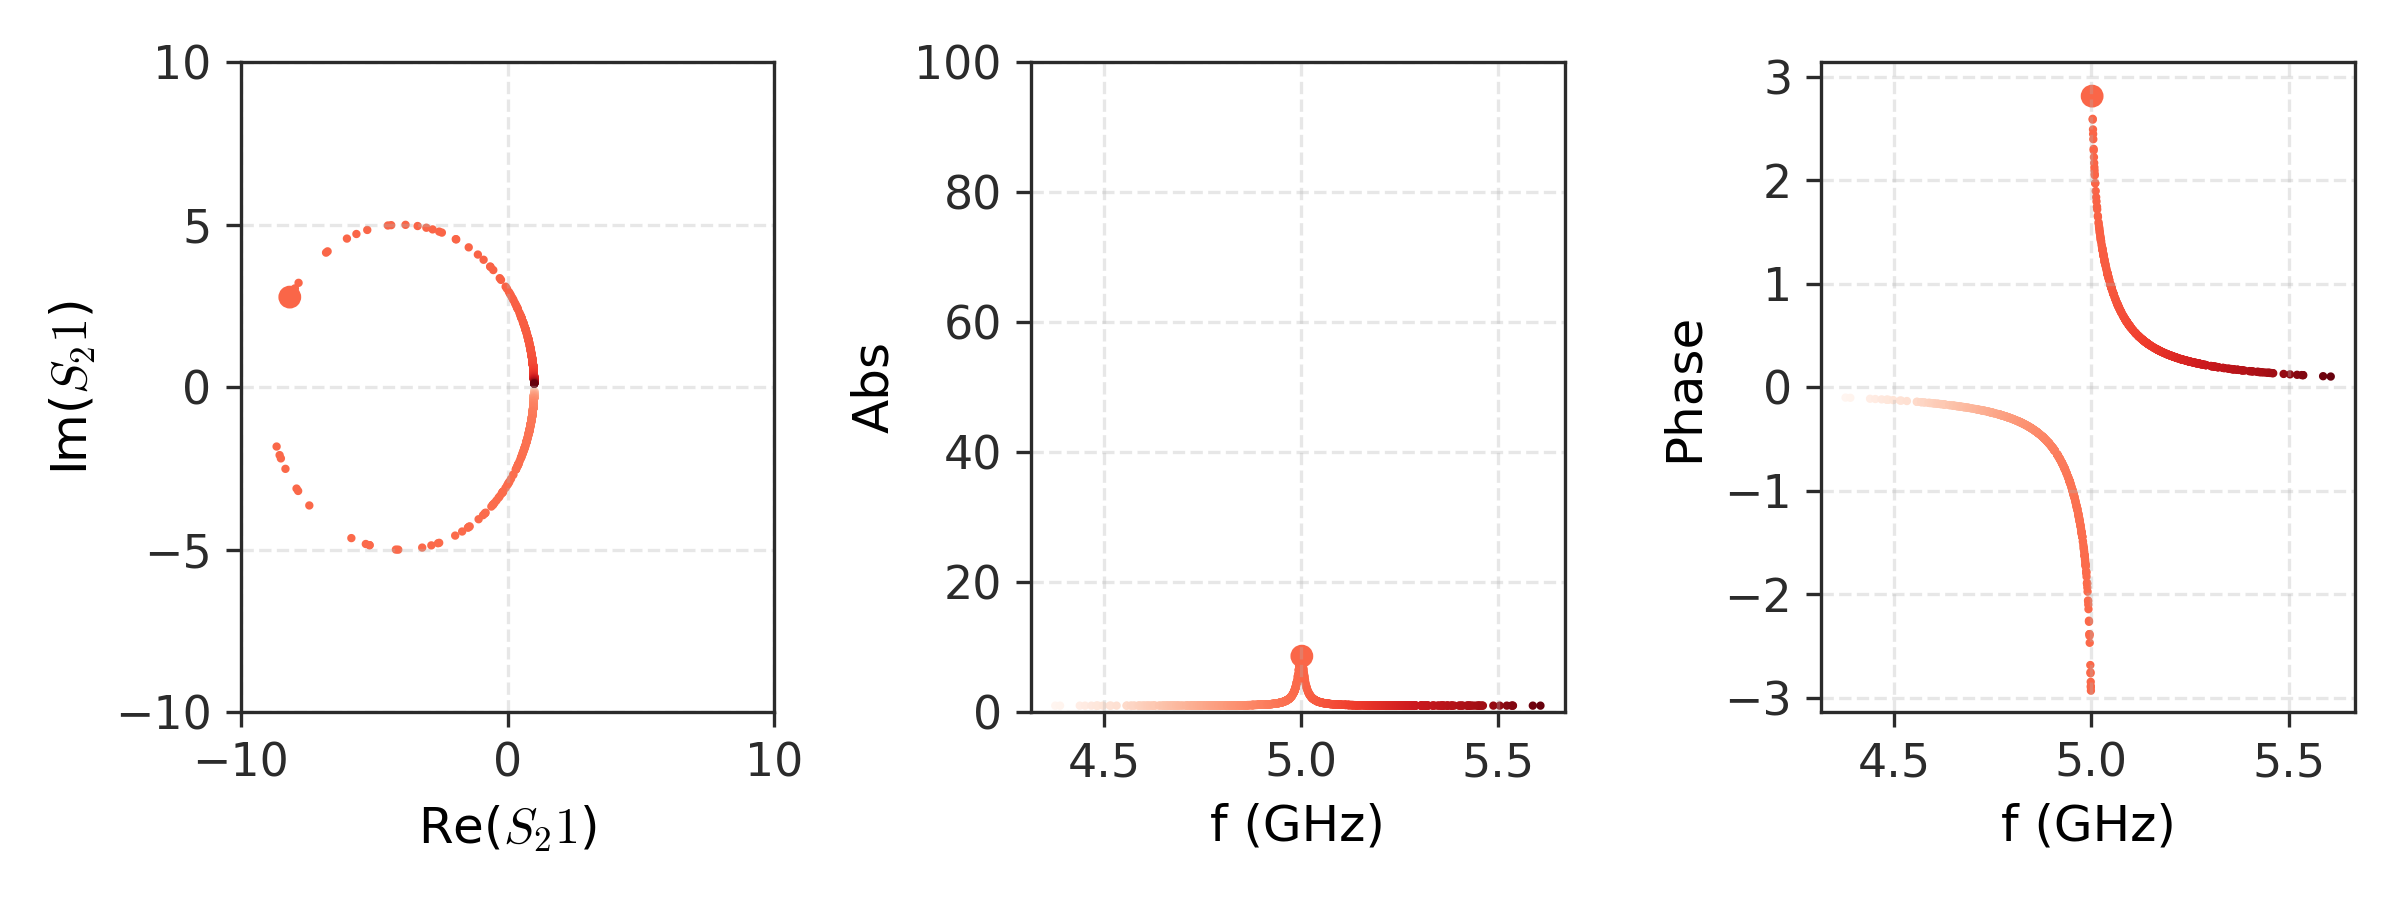

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].set_xlabel("Re($S_21$)", fontsize=12)
ax[0].set_ylabel("Im($S_21$)", fontsize=12)
ax[1].set_xlabel("f (GHz)", fontsize=12)
ax[1].set_ylabel("Abs", fontsize=12)
ax[2].set_xlabel("f (GHz)", fontsize=12)
ax[2].set_ylabel("Phase", fontsize=12)

ax[0].set_xlim([-10, 10])
ax[0].set_ylim([-10, 10])
ax[1].set_ylim([0, 100])
ax[2].set_ylim([-np.pi, np.pi])

# First plot
reflection = resonator_kernel(freq_list, system_parameters)
sc = ax[0].scatter(
        np.real(reflection),
        np.imag(reflection),
        c=freq_list,
        s=size_list,
        cmap="Reds"
    )
amp = ax[1].scatter(
    freq_list / GHz,
    np.abs(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
phase = ax[2].scatter(
    freq_list / GHz,
    np.angle(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
plt.tight_layout()

# Update function - must be here to refference variables from above
def resonator_plot(Q_load: float, Q_coupling: float, phi: float, att: float, tau: float):
    system_parameters.update(
        {
            "Q_load": Q_load,
            "Q_coupling": Q_coupling,
            "phi": phi,
            "att": att,
            "tau": tau / 10**10
        })
    print(system_parameters)

    reflection = resonator_kernel(freq_list, system_parameters)
    sc.set_offsets(np.c_[np.real(reflection), np.imag(reflection)])
    amp.set_offsets(np.c_[freq_list / GHz, np.abs(reflection)])
    phase.set_offsets(np.c_[freq_list / GHz, np.angle(reflection)])
    
# Widgets
# color_buttons = RadioButtons(options=['blue', 'green', 'red'])    
Q_load_widget = widgets.FloatLogSlider(
#     min=100, max=10000, step=100, 
    base=10, min=0, max=3,value=np.log10(system_parameters["Q_load"]),
    description="Q_load",
    layout=widgets.Layout(width='800px', height='100px'))
Q_coupling_widget = widgets.FloatLogSlider(
    base=10, min=0, max=2.5, value=np.log10(system_parameters["Q_coupling"]),
#     min=100, max=10000, step=100, value=system_parameters["Q_coupling"]
    description="Q_coupling",
    layout=widgets.Layout(width='800px', height='100px'))
phi_widget = FloatSlider(
    min=0, max=2 * np.pi,
    description="phi", value=system_parameters["phi"])
att_widget = FloatSlider(
    min=0, max=10,
    description="Attenuation", value=system_parameters["att"],
    layout=widgets.Layout(width='800px', height='100px'))
tau_widget = FloatSlider(
    min=0, max=100, step=1,
    description="Tau", value=system_parameters["tau"],
    layout=widgets.Layout(width='800px', height='100px'))

quality_box = widgets.HBox([Q_load_widget, Q_coupling_widget])
external_box = widgets.HBox([att_widget, tau_widget])
other_box = widgets.HBox([phi_widget])
ui = widgets.VBox([quality_box, external_box, other_box])

In [9]:
out = widgets.interactive_output(
    resonator_plot, 
    {"Q_load":Q_load_widget, 
    "Q_coupling": Q_coupling_widget, 
    "phi":phi_widget,
    "att": att_widget,
     "tau": tau_widget
    }
    )

display(ui, out)

Output()

# Transmission

<IPython.core.display.Javascript object>


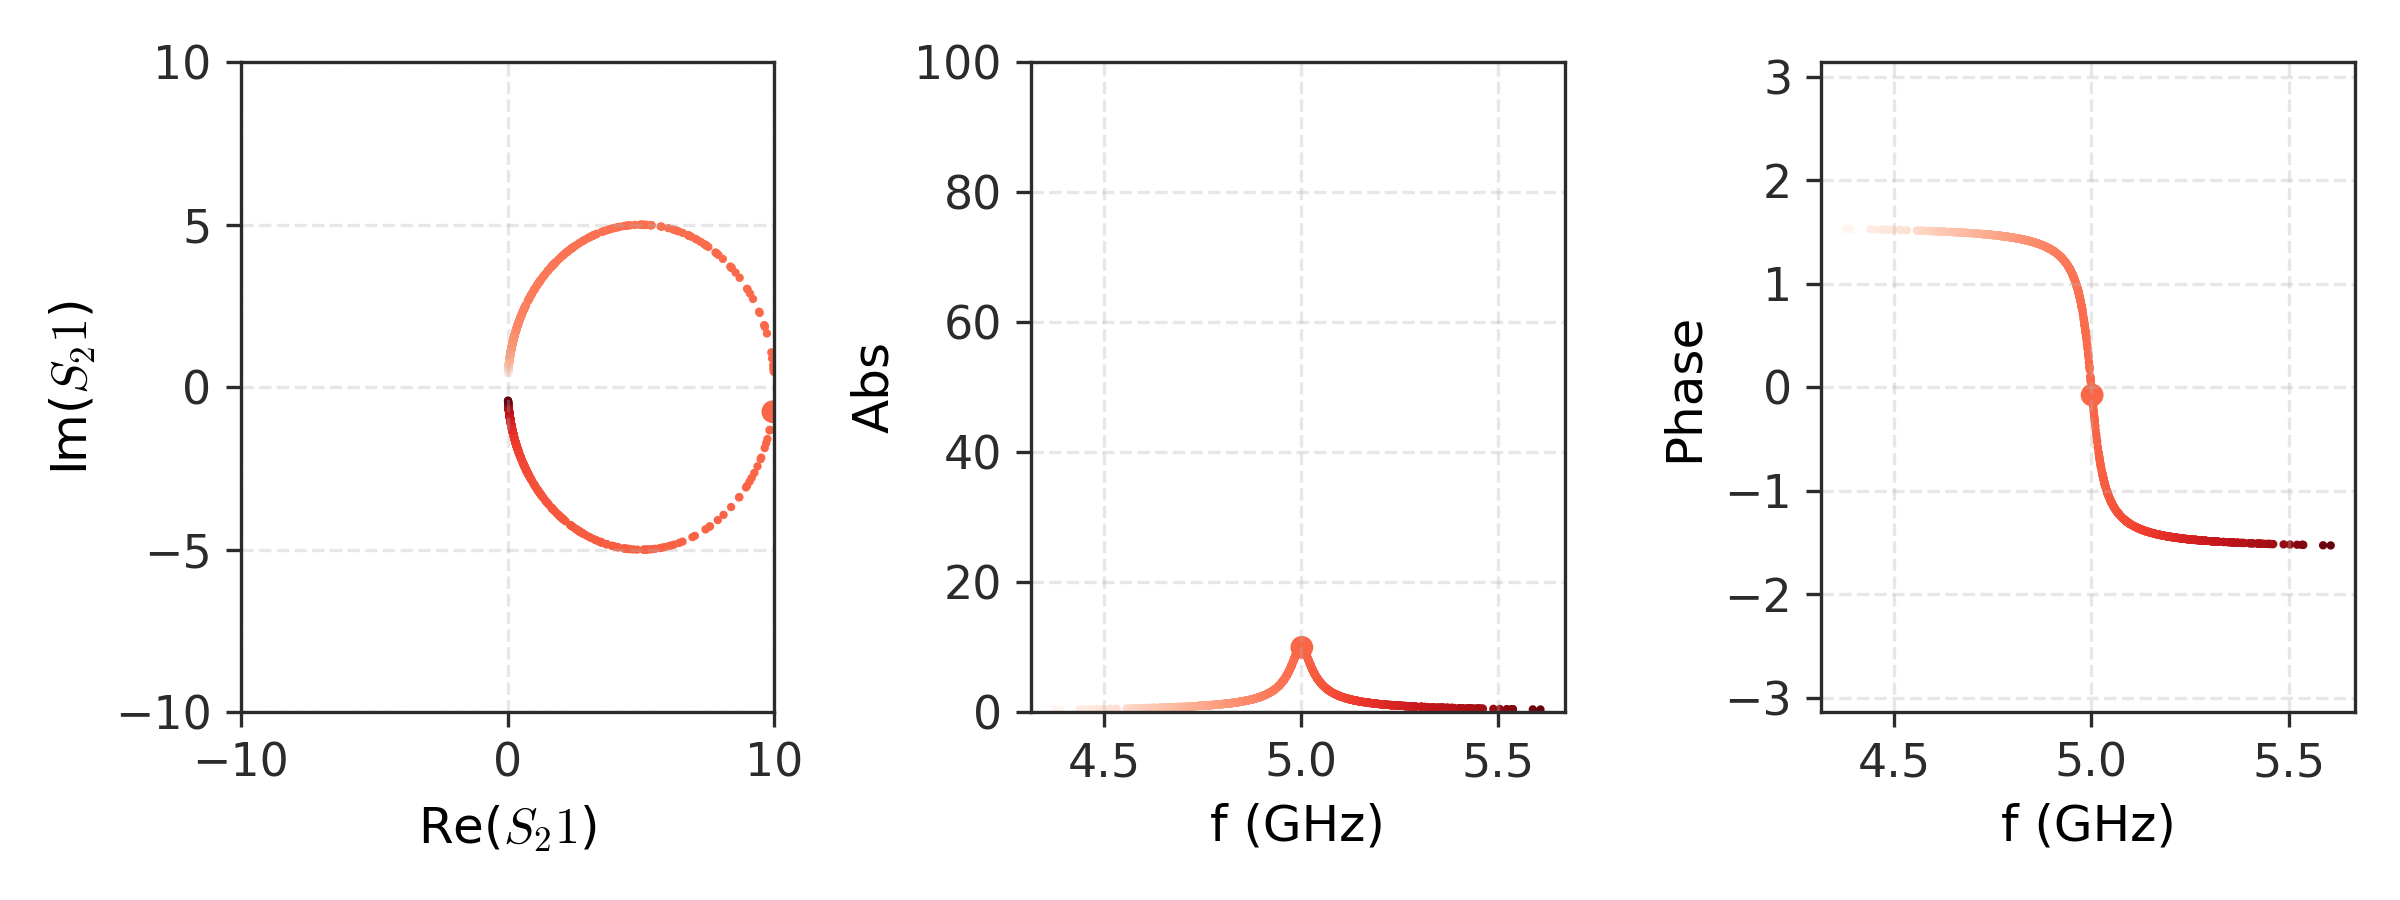

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].set_xlabel("Re($S_21$)", fontsize=12)
ax[0].set_ylabel("Im($S_21$)", fontsize=12)
ax[1].set_xlabel("f (GHz)", fontsize=12)
ax[1].set_ylabel("Abs", fontsize=12)
ax[2].set_xlabel("f (GHz)", fontsize=12)
ax[2].set_ylabel("Phase", fontsize=12)

ax[0].set_xlim([-10, 10])
ax[0].set_ylim([-10, 10])
ax[1].set_ylim([0, 100])
ax[2].set_ylim([-np.pi, np.pi])

# First plot
reflection = resonator_kernel_transmission(freq_list, system_parameters)
sc = ax[0].scatter(
        np.real(reflection),
        np.imag(reflection),
        c=freq_list,
        s=size_list,
        cmap="Reds"
    )
amp = ax[1].scatter(
    freq_list / GHz,
    np.abs(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
phase = ax[2].scatter(
    freq_list / GHz,
    np.angle(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
plt.tight_layout()

# Update function - must be here to refference variables from above
def resonator_plot(Q_load: float, Q_coupling: float, phi: float, att: float, tau: float):
    system_parameters.update(
        {
            "Q_load": Q_load,
            "Q_coupling": Q_coupling,
            "phi": phi,
            "att": att,
            "tau": tau / 10**10
        })
    print(system_parameters)

    reflection = resonator_kernel_transmission(freq_list, system_parameters)
    sc.set_offsets(np.c_[np.real(reflection), np.imag(reflection)])
    amp.set_offsets(np.c_[freq_list / GHz, np.abs(reflection)])
    phase.set_offsets(np.c_[freq_list / GHz, np.angle(reflection)])
    
# Widgets
# color_buttons = RadioButtons(options=['blue', 'green', 'red'])    
Q_load_widget = widgets.FloatLogSlider(
#     min=100, max=10000, step=100, 
    base=10, min=0, max=3,value=np.log10(system_parameters["Q_load"]),
    description="Q_load",
    layout=widgets.Layout(width='800px', height='100px'))
Q_coupling_widget = widgets.FloatLogSlider(
    base=10, min=0, max=2.5, value=np.log10(system_parameters["Q_coupling"]),
#     min=100, max=10000, step=100, value=system_parameters["Q_coupling"]
    description="Q_coupling",
    layout=widgets.Layout(width='800px', height='100px'))
phi_widget = FloatSlider(
    min=0, max=2 * np.pi,
    description="phi", value=system_parameters["phi"])
att_widget = FloatSlider(
    min=0, max=10,
    description="Attenuation", value=system_parameters["att"],
    layout=widgets.Layout(width='800px', height='100px'))
tau_widget = FloatSlider(
    min=0, max=100, step=1,
    description="Tau", value=system_parameters["tau"],
    layout=widgets.Layout(width='800px', height='100px'))

quality_box = widgets.HBox([Q_load_widget, Q_coupling_widget])
external_box = widgets.HBox([att_widget, tau_widget])
other_box = widgets.HBox([phi_widget])
ui = widgets.VBox([quality_box, external_box, other_box])

In [19]:
out = widgets.interactive_output(
    resonator_plot, 
    {"Q_load":Q_load_widget, 
    "Q_coupling": Q_coupling_widget, 
    "phi":phi_widget,
    "att": att_widget,
     "tau": tau_widget
    }
    )

display(ui, out)

Output()

# Using `Probst` Package

In [190]:
df = pd.read_csv('/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_Ay_xmon_res_01.txt',sep='\t')
df.columns = ["freq", "mag", "phase"]

df

,freq,mag,phase
0,6120025088,0.363181,-2.71462
1,6120050176,0.366568,-2.71313
2,6120074752,0.363852,-2.74377
3,6120099840,0.361983,-2.71457
4,6120124928,0.362364,-2.73108
...,...,...,...
995,6144900096,0.347456,-2.38267
996,6144925184,0.347677,-2.39350
997,6144949760,0.346084,-2.38588
998,6144974848,0.350835,-2.38689


/Users/CCCP/.config/python_vi/qubit/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


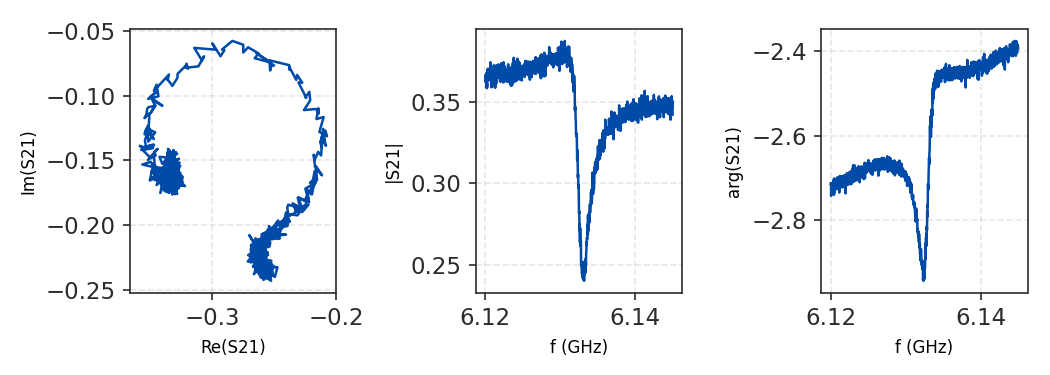

In [198]:
port1 = circuit.reflection_port(
    f_data=df["freq"].values,
    z_data_raw= df["mag"] * np.exp(1j*df["phase"])
)
port1.autofit(
#     electric_delay=0
)

fig, ax_all = plt.subplots(1, 3, figsize=(7, 2.5))
freq_axis = port1.f_data * 1e-9

ax = ax_all[0]
ax.plot(port1.z_data_raw.real, port1.z_data_raw.imag, label='rawdata')
# ax.plot(port1.z_data_sim.real, port1.z_data_sim.imag, label='fit', color="C8")
ax.set_xlabel('Re(S21)',fontsize=8)
ax.set_ylabel('Im(S21)',fontsize=8)

ax = ax_all[1]
ax.plot(freq_axis, np.absolute(port1.z_data_raw), label='rawdata')
# ax.plot(freq_axis, np.absolute(port1.z_data_sim), label='fit', color="C8")
ax.set_xlabel('f (GHz)',fontsize=8)
ax.set_ylabel('|S21|',fontsize=8)

ax = ax_all[2]
ax.plot(freq_axis, np.angle(port1.z_data_raw), label='rawdata')
# ax.plot(freq_axis, np.angle(port1.z_data_sim), label='fit', color="C8")
ax.set_xlabel('f (GHz)',fontsize=8)
ax.set_ylabel('arg(S21)',fontsize=8)

plt.tight_layout()
plt.show()
plt.savefig("./output/2021-01-11_circle-fit/raw-experimental-data.png")

In [14]:
port1.plotrawdata()